In [2]:
!pip install -q pycocotools albumentations


In [3]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="4olLgJ0J24IIoIUYzX5P")
project = rf.workspace("postcards-c0lec").project("ring-segmentation-zdria")
version = project.version(2)
dataset = version.download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ring-Segmentation-2 in coco-segmentation:: 100%|██████████| 258/258 [00:00<00:00, 3616.47it/s]


In [5]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection
import os
import numpy as np
from PIL import Image
import json
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
train_data_path = os.path.join(dataset.location, "train")  # e.g. /content/ring-segmentation-2/train
valid_data_path = os.path.join(dataset.location, "valid")

# Transform
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
class CocoSegmentationDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super(CocoSegmentationDataset, self).__init__(img_folder, ann_file)
        self._transforms = transforms
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        boxes = []
        labels = []
        masks = []

        for ann in anns:
            if ann.get("iscrowd", 0) == 1:
                continue

            labels.append(ann['category_id'])
            boxes.append(ann['bbox'])  # COCO format is [x, y, width, height]
            rle = coco.annToRLE(ann)
            mask = coco.annToMask(ann)
            masks.append(mask)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        boxes[:, 2:] += boxes[:, :2]  # Convert [x, y, w, h] to [x1, y1, x2, y2]
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(anns),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self._transforms is not None:
            img = self._transforms(img)

        return img, target

In [7]:
# Load datasets
train_dataset = CocoSegmentationDataset(
    img_folder=train_data_path,
    ann_file=os.path.join(train_data_path, '_annotations.coco.json'),
    transforms=transform
)

valid_dataset = CocoSegmentationDataset(
    img_folder=valid_data_path,
    ann_file=os.path.join(valid_data_path, '_annotations.coco.json'),
    transforms=transform
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load pretrained model

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT  # or COCO_V1 for legacy
model = maskrcnn_resnet50_fpn(weights=weights)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 95.7MB/s]


In [8]:
# Update number of classes
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_mask_features = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(in_mask_features, 256, num_classes)

model.to(device)

# Optimizer & Scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item()}")

# Save model
torch.save(model.state_dict(), "ring_segmentation_mask_rcnn.pth")

# Inference (optional)
model.eval()
with torch.no_grad():
    for images, _ in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for output in outputs:
            print(output['labels'], output['masks'].shape)

Epoch [1/10], Loss: 0.24705110490322113
Epoch [2/10], Loss: 0.29564547538757324
Epoch [3/10], Loss: 0.13863378763198853
Epoch [4/10], Loss: 0.1204572394490242
Epoch [5/10], Loss: 0.13620541989803314
Epoch [6/10], Loss: 0.2003709226846695
Epoch [7/10], Loss: 0.1237332671880722
Epoch [8/10], Loss: 0.127329483628273
Epoch [9/10], Loss: 0.13910642266273499
Epoch [10/10], Loss: 0.09994561225175858
tensor([1], device='cuda:0') torch.Size([1, 1, 640, 360])
tensor([1, 1], device='cuda:0') torch.Size([2, 1, 640, 360])
tensor([1, 1, 1, 1], device='cuda:0') torch.Size([4, 1, 640, 360])
tensor([1], device='cuda:0') torch.Size([1, 1, 640, 360])
tensor([1], device='cuda:0') torch.Size([1, 1, 640, 360])
tensor([1], device='cuda:0') torch.Size([1, 1, 640, 360])
tensor([1], device='cuda:0') torch.Size([1, 1, 640, 360])
tensor([1, 1], device='cuda:0') torch.Size([2, 1, 640, 360])
tensor([1, 1], device='cuda:0') torch.Size([2, 1, 640, 360])
tensor([1, 1, 1], device='cuda:0') torch.Size([3, 1, 640, 360])


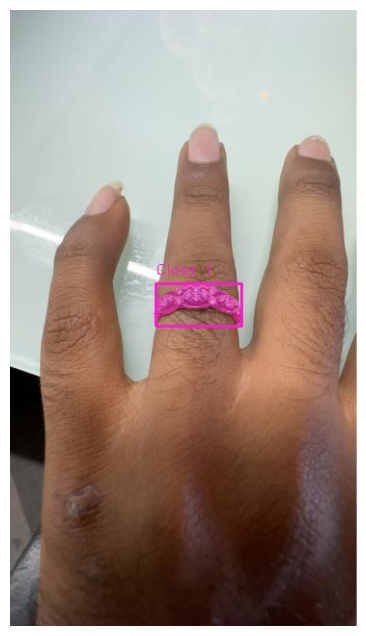

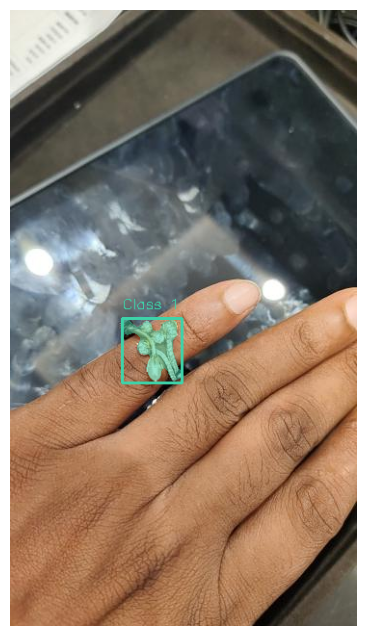

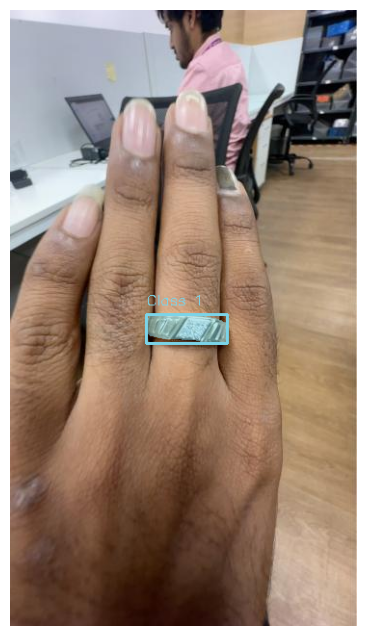

In [9]:
import matplotlib.pyplot as plt
import random
import torchvision
import cv2

# Helper to show masks on image
def visualize_predictions(img_tensor, pred, threshold=0.5):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8).copy()

    masks = pred['masks']
    boxes = pred['boxes']
    labels = pred['labels']
    scores = pred['scores']

    for i in range(len(masks)):
        if scores[i] < threshold:
            continue
        mask = masks[i, 0].cpu().numpy()
        color = [random.randint(0, 255) for _ in range(3)]

        # Apply mask
        img[mask > 0.5] = img[mask > 0.5] * 0.5 + np.array(color) * 0.5

        # Draw bounding box
        box = boxes[i].cpu().numpy().astype(int)
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Put label text
        label = labels[i].item()
        cv2.putText(img, f"Class {label}", (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(img)
    plt.show()

# Inference on a few validation images
model.eval()
with torch.no_grad():
    for i in range(3):  # show 3 samples
        img, _ = valid_dataset[i]
        pred = model([img.to(device)])[0]
        visualize_predictions(img, pred, threshold=0.6)


In [10]:
torch.save(model.state_dict(), "mask_rcnn_ring_segmentation_weights.pth")